<a href="https://colab.research.google.com/github/Sebastian-Frey/Timeseries-Forecasting-leveraging-LLMs/blob/main/paper_data_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# !pip install -q polars pyarrow

from pathlib import Path
import polars as pl

# -------- paths --------
IN_DIR = Path("/content/drive/MyDrive/colab_data/cleaned_cpu/paper/start_data_thesis")
OUT_DIR = Path("/content/drive/MyDrive/colab_data/cleaned_cpu/paper")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_PARQUET = OUT_DIR / "weekly_processed.parquet"

DROP_COLS = {"admatchedquery", "addestinationurl", "cost_per_click"}
KEEP_COLS_BASE = [
    "keyword", "devicecategory", "adcost", "adclicks",
    "impressions", "searchtype", "exchangerateusd", "domain"
]

# -------- scan all parquet files under IN_DIR --------
paths = [
    str(p) for p in IN_DIR.rglob("*.parquet")
    if "__MACOSX" not in str(p)
    and not p.name.startswith(("._", "."))
]

if not paths:
    raise FileNotFoundError(f"No parquet files found under {IN_DIR}")

print(f"Found {len(paths)} parquet files under {IN_DIR}. Building lazy scan…")

# Polars 1.30+: missing_columns="insert"
# extra_columns="ignore" avoids crashes when some files have extra fields (e.g., week)
lf = pl.scan_parquet(
    paths,
    missing_columns="insert",
    extra_columns="ignore",
)

names = set(lf.collect_schema().names())
for req in ("date", "keyword"):
    if req not in names:
        raise ValueError(f"Missing required '{req}'. Found: {sorted(names)}")

present_keep = [c for c in KEEP_COLS_BASE if c in names]

# -------- select minimal columns --------
lf_sel = lf.select(
    pl.col("date"),
    pl.col("keyword").cast(pl.Utf8).alias("keyword"),
    *[pl.col(c) for c in present_keep if c != "keyword"],
)

# -------- robust date parsing --------
date_str = pl.col("date").cast(pl.Utf8, strict=False)

fmt_attempts = [
    "%Y-%m-%d",
    "%Y/%m/%d",
    "%d/%m/%Y",
    "%m/%d/%Y",
    "%Y-%m-%d %H:%M:%S",
    "%Y/%m/%d %H:%M:%S",
    "%Y-%m-%dT%H:%M:%S",
    "%Y-%m-%dT%H:%M:%S%.f",
]

parsed_attempts = [date_str.str.strptime(pl.Date, format=f, strict=False) for f in fmt_attempts]
parsed_attempts += [
    pl.col("date").cast(pl.Date, strict=False),
    pl.col("date").cast(pl.Datetime, strict=False).dt.date(),
]

parsed_date = pl.coalesce(parsed_attempts).alias("date_parsed")

# -------- preflight check --------
print("🔎 Preflight: validating date parsing on a sample…")
bad = (
    lf_sel
    .with_columns(parsed_date)
    .select(pl.col("date"), pl.col("date_parsed"))
    .filter(pl.col("date_parsed").is_null())
    .limit(20)
    .collect(engine="streaming")
)

if bad.height > 0:
    print("❌ Could not parse these 'date' values (up to 20):")
    print(bad)
    raise ValueError("Date parsing failed for some rows. Add a matching format.")
else:
    print("✅ Preflight OK.")

# -------- build weekly + apply FX + drop cols --------
lf_clean = (
    lf_sel
    .with_columns(parsed_date)
    .drop("date")
    .with_columns(
        pl.concat_str([
            pl.col("date_parsed").dt.strftime("%V"),
            pl.lit("-"),
            pl.col("date_parsed").dt.strftime("%G"),
        ]).alias("week"),
    )
    .drop("date_parsed")
    .drop(list(DROP_COLS), strict=False)
    # apply exchange rate to adcost (keep adcost as the FX-adjusted value)
    .with_columns(
        pl.col("adcost").cast(pl.Float64, strict=False),
        pl.col("exchangerateusd").cast(pl.Float64, strict=False),
    )
    .with_columns(
        pl.when(pl.col("adcost").is_not_null() & pl.col("exchangerateusd").is_not_null())
          .then(pl.col("adcost") * pl.col("exchangerateusd"))
          .otherwise(pl.col("adcost"))
          .alias("adcost")
    )
    .select("week", "keyword", *[c for c in present_keep if c != "keyword"])
)

print(f"🧮 Writing {OUT_PARQUET} …")
lf_clean.sink_parquet(
    str(OUT_PARQUET),
    compression="zstd",
    statistics=True,
    row_group_size=8192,
)

print(f"✅ Done. Wrote: {OUT_PARQUET}")
print(pl.read_parquet(OUT_PARQUET, n_rows=10))


Found 4410 parquet files under /content/drive/MyDrive/colab_data/cleaned_cpu/paper/start_data_thesis. Building lazy scan…
🔎 Preflight: validating date parsing on a sample…


In [ ]:
# Polars-only: unify keywords + drop exchangerateusd

import os
import polars as pl

DATA_DIR = "/content/drive/MyDrive/colab_data/cleaned_cpu"
PAPER_DIR = os.path.join(DATA_DIR, "paper")
os.makedirs(PAPER_DIR, exist_ok=True)

IN_FP  = os.path.join(PAPER_DIR, "weekly_processed.parquet")
OUT_FP = os.path.join(PAPER_DIR, "weekly_processed_kn.parquet")  # <- final output

if not os.path.exists(IN_FP):
    raise FileNotFoundError(IN_FP)

def pl_unify_keyword(expr: pl.Expr) -> pl.Expr:
    s = expr.cast(pl.Utf8).str.to_lowercase()
    s = s.str.replace_all(r"\.com|[.\-\+\"']", " ")
    s = s.str.replace_all(r"\b(in|a)\b", "")
    s = s.str.replace_all(r"\s+", " ").str.strip_chars()

    has_car     = s.str.contains(r"\bcar\b")
    has_rental  = s.str.contains(r"\brental\b")
    has_airport = s.str.contains(r"\bairport\b")

    tail = s.str.replace_all(r"\b(car|rental|airport)\b", "")
    tail = tail.str.replace_all(r"\s+", " ").str.strip_chars()

    prefix = pl.when(has_car & has_rental).then(pl.lit("car rental")).otherwise(pl.lit(""))
    prefix = (prefix + pl.lit(" ") + pl.when(has_airport).then(pl.lit("airport")).otherwise(pl.lit("")))
    prefix = prefix.str.replace_all(r"\s+", " ").str.strip_chars()

    return (prefix + pl.lit(" ") + tail).str.replace_all(r"\s+", " ").str.strip_chars()

print(f"CPU Processing: {IN_FP}")

df = pl.read_parquet(IN_FP)

if "keyword" not in df.columns:
    raise ValueError("No 'keyword' column in input parquet.")

df_out = (
    df.with_columns(keyword=pl_unify_keyword(pl.col("keyword")))
      .drop("exchangerateusd", strict=False)  # drop if present
)

df_out.write_parquet(OUT_FP, compression="zstd")
print(f"✅ Saved: {OUT_FP}")
print(df_out.select(["week", "keyword"]).head(10))


In [ ]:
# !pip -q install polars pyarrow sentence-transformers tqdm

# One self-contained cell:
# - Input: paper/weekly_processed_kn.parquet  (keyword unified, exchangerateusd dropped)
# - Domain-aware filter: keep (domain, keyword) only if present >=110 distinct weeks WITHIN that domain
# - Similarity metrics: computed per (week, keyword) using ALL keywords in that week across ALL domains (global weekly universe)
# - Output: paper/weekly_processed_sim.parquet  (all original rows that survive filter + attached metrics)

from pathlib import Path
import math, gc
import numpy as np
import polars as pl
from tqdm.auto import tqdm
import torch
from sentence_transformers import SentenceTransformer

# ------------------ CONFIG ------------------
BASE = Path("/content/drive/MyDrive/colab_data/cleaned_cpu")
PAPER = BASE / "paper"
PAPER.mkdir(parents=True, exist_ok=True)

IN_PARQUET  = PAPER / "weekly_processed_kn.parquet"   # <- your normalized weekly file
OUT_PARQUET = PAPER / "weekly_processed_sim.parquet"

MIN_WEEKS   = 110
TOP_FRAC    = 0.25
MODEL_NAME  = "sentence-transformers/all-MiniLM-L6-v2"
BATCH_SIZE  = 1024
EMB_DTYPE   = np.float16

IDX_CSV = PAPER / f"keyword_domain_index_{MIN_WEEKS}.csv"
EMB_NPY = PAPER / f"keyword_embeddings_{MIN_WEEKS}.npy"
SIM_NPY = PAPER / f"keyword_similarity_matrix_{MIN_WEEKS}.npy"
# -------------------------------------------

if not IN_PARQUET.exists():
    raise FileNotFoundError(IN_PARQUET)

# ---------- Step 1: valid (domain, keyword) pairs with ≥ MIN_WEEKS ----------
print(f"📥 Loading {IN_PARQUET.name} and computing (domain, keyword) with ≥{MIN_WEEKS} weeks…")

lf_base = pl.scan_parquet(str(IN_PARQUET)).select(
    pl.col("week").cast(pl.Utf8),
    pl.col("keyword").cast(pl.Utf8),
    pl.col("domain").cast(pl.Utf8, strict=False),
)

valid_pairs = (
    lf_base.unique(subset=["domain", "keyword", "week"])
           .group_by(["domain", "keyword"])
           .agg(pl.len().alias("n_weeks"))
           .filter(pl.col("n_weeks") >= MIN_WEEKS)
           .select(["domain", "keyword", "n_weeks"])
           .sort(["domain", "keyword"])
           .collect(engine="streaming")
)

M = valid_pairs.height
print(f"✅ Valid (domain, keyword) pairs: {M:,}")
if M == 0:
    raise RuntimeError("No (domain, keyword) pairs meet MIN_WEEKS.")

valid_pairs.write_csv(IDX_CSV)
print(f"💾 Wrote index: {IDX_CSV}")

# Keywords for embeddings = union of keywords that survive in at least one domain
keywords = valid_pairs.select("keyword").unique().sort("keyword")["keyword"].to_list()
K = len(keywords)
print(f"✅ Unique keywords in valid pairs: {K:,}")
kw2idx = {kw: i for i, kw in enumerate(keywords)}

# ---------- Step 2: embeddings ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🧠 Loading model '{MODEL_NAME}' on {device} …")
model = SentenceTransformer(MODEL_NAME, device=device)
torch.backends.cudnn.benchmark = True
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

use_amp = (device == "cuda")
amp_dtype = torch.bfloat16 if (device=="cuda" and torch.cuda.get_device_capability()[0] >= 8) else torch.float16

def embed_texts(texts, batch_size=BATCH_SIZE):
    out = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding keywords"):
        batch = texts[i:i+batch_size]
        with torch.inference_mode():
            if use_amp:
                with torch.autocast(device_type="cuda", dtype=amp_dtype):
                    E = model.encode(batch, batch_size=len(batch), convert_to_numpy=True,
                                     show_progress_bar=False, normalize_embeddings=True)
            else:
                E = model.encode(batch, batch_size=len(batch), convert_to_numpy=True,
                                 show_progress_bar=False, normalize_embeddings=True)
        out.append(E.astype(np.float32, copy=False))
    return np.vstack(out)

print("🔧 Computing embeddings …")
emb_fp32 = embed_texts(keywords, batch_size=BATCH_SIZE)
emb = emb_fp32.astype(EMB_DTYPE, copy=False)
np.save(EMB_NPY, emb)
del emb_fp32; gc.collect()
print(f"💾 Saved embeddings: {EMB_NPY}  shape={emb.shape}, dtype={emb.dtype}")

# ---------- Step 3: cosine similarity matrix ----------
print("📐 Building full cosine similarity matrix …")
E32 = emb.astype(np.float32, copy=False)
S = (E32 @ E32.T).astype(EMB_DTYPE, copy=False)   # normalized => cosine = dot
np.save(SIM_NPY, S)
print(f"💾 Saved similarity matrix: {SIM_NPY}  shape={S.shape}, dtype={S.dtype}")
del E32, S; gc.collect()

# ---------- Step 4: global-week metrics per (week, keyword) ----------
print("🧮 Computing global-week semantic metrics (neighbor set = ALL domains) …")

def prev_week_iso(ww_yyyy: str):
    from datetime import date, timedelta
    try:
        w, y = ww_yyyy.split("-")
        d = date.fromisocalendar(int(y), int(w), 1)
        d_prev = d - timedelta(days=7)
        iso = d_prev.isocalendar()
        return f"{iso.week:02d}-{iso.year}"
    except Exception:
        return None

def topk_by_similarity_weighted_mean(sim_vals: np.ndarray, counts: np.ndarray, frac: float):
    M = sim_vals.size
    if M == 0:
        return float("nan"), 0
    k = int(math.ceil(frac * M))
    k = max(1, min(k, M))
    order = np.argsort(-sim_vals)[:k]
    w = counts[order].astype(np.int64, copy=False)
    s = sim_vals[order].astype(np.float32, copy=False)
    total = int(w.sum())
    if total <= 0:
        return float("nan"), 0
    return float((s * w).sum() / total), total

# Global counts built from ONLY keywords that are in the embedding universe (valid in >=1 domain)
df_rows_global = (
    pl.scan_parquet(str(IN_PARQUET))
      .select(["week", "keyword"])
      .with_columns(
          pl.col("week").cast(pl.Utf8),
          pl.col("keyword").cast(pl.Utf8),
      )
      .filter(pl.col("keyword").is_in(pl.Series("kw_ok", keywords)))
)

wk_counts = (
    df_rows_global.group_by(["week", "keyword"])
                  .len()
                  .rename({"len": "count"})
                  .collect(engine="streaming")
)

weeks = wk_counts.select("week").unique().to_series().to_list()
sim = np.load(SIM_NPY, mmap_mode="r")

# Build week lookups
week_idx, week_cnt, week_kws, week_pos = {}, {}, {}, {}
for w in weeks:
    sub = wk_counts.filter(pl.col("week") == w)
    kws = sub["keyword"].to_list()
    cnt = np.asarray(sub["count"].to_numpy(), dtype=np.int32)
    idxs = np.asarray([kw2idx[k] for k in kws], dtype=np.int32)
    week_kws[w] = kws
    week_cnt[w] = cnt
    week_idx[w] = idxs
    week_pos[w] = {idxs[i]: i for i in range(len(idxs))}

records = []
for w in tqdm(weeks, desc="Weeks"):
    idxs_this = week_idx[w]
    cnts_this = week_cnt[w]
    kws_this  = week_kws[w]
    n = len(idxs_this)

    if n >= 1:
        S_this = np.asarray(sim[np.ix_(idxs_this, idxs_this)], dtype=np.float32)
        np.fill_diagonal(S_this, -np.inf)
    else:
        S_this = np.empty((0, 0), dtype=np.float32)

    w_prev = prev_week_iso(w)
    if w_prev in week_idx:
        idxs_prev = week_idx[w_prev]
        cnts_prev = week_cnt[w_prev]
        pos_prev  = week_pos[w_prev]
        S_last = np.asarray(sim[np.ix_(idxs_this, idxs_prev)], dtype=np.float32)
    else:
        idxs_prev = np.empty((0,), dtype=np.int32)
        cnts_prev = np.empty((0,), dtype=np.int32)
        pos_prev  = {}
        S_last = np.empty((n, 0), dtype=np.float32)

    for i in range(n):
        kw_i = kws_this[i]
        idx_i = idxs_this[i]

        # this week
        if n >= 2:
            sim_row = S_this[i]
            counts = cnts_this.copy()
            counts[i] = 0
            mask = counts > 0
            mean_this, used_this = topk_by_similarity_weighted_mean(sim_row[mask], counts[mask], TOP_FRAC)
        else:
            mean_this, used_this = float("nan"), 0

        # last week
        if idxs_prev.size > 0:
            sim_prev = S_last[i]
            counts_prev = cnts_prev.copy()
            jprev = pos_prev.get(idx_i, None)
            if jprev is not None:
                counts_prev[jprev] = 0
            mask_prev = counts_prev > 0
            mean_last, used_last = topk_by_similarity_weighted_mean(sim_prev[mask_prev], counts_prev[mask_prev], TOP_FRAC)
        else:
            mean_last, used_last = float("nan"), 0

        records.append((w, kw_i, float(mean_this), float(mean_last), int(used_this), int(used_last)))

metrics_df = pl.DataFrame(
    records,
    schema=[
        ("week", pl.Utf8),
        ("keyword", pl.Utf8),
        ("avg_sim_top25_this_week", pl.Float32),
        ("avg_sim_top25_last_week", pl.Float32),
        ("n_sim_this_week", pl.Int32),
        ("n_sim_last_week", pl.Int32),
    ],
)

# ---------- Step 5: filter rows by valid (domain, keyword), then attach global metrics ----------
print("🔗 Filtering rows by (domain, keyword) ≥ MIN_WEEKS and attaching global-week metrics …")

valid_pairs_small = valid_pairs.select(["domain", "keyword"]).unique()

lf_rows_full = (
    pl.scan_parquet(str(IN_PARQUET))
      .with_columns(
          pl.col("domain").cast(pl.Utf8, strict=False),
          pl.col("week").cast(pl.Utf8),
          pl.col("keyword").cast(pl.Utf8),
      )
      .join(valid_pairs_small.lazy(), on=["domain", "keyword"], how="inner")   # domain-aware survival filter
)

lf_metrics = metrics_df.lazy()

out_lf = lf_rows_full.join(lf_metrics, on=["week", "keyword"], how="left")

print(f"🧮 Writing: {OUT_PARQUET}")
out_lf.sink_parquet(
    str(OUT_PARQUET),
    compression="zstd",
    statistics=True,
    row_group_size=8192,
)

print(f"✅ Done. Wrote: {OUT_PARQUET}")
print(pl.read_parquet(OUT_PARQUET, n_rows=8))


In [3]:
# !pip -q install polars pyarrow

from pathlib import Path
import re
import polars as pl

# -------- paths --------
BASE = Path("/content/drive/MyDrive/colab_data/cleaned_cpu/paper")
IN_ROWS = BASE / "weekly_processed_sim.parquet"
OUT_AGG = BASE / "weekly_aggregated_by_week_domain_keyword.parquet"

if not IN_ROWS.exists():
    raise FileNotFoundError(IN_ROWS)

# -------- helper --------
def norm_suffix(s: str) -> str:
    s2 = str(s).lower().strip()
    s2 = re.sub(r"\s+", "_", s2)
    s2 = re.sub(r"[^a-z0-9_]+", "_", s2)
    s2 = re.sub(r"_+", "_", s2).strip("_")
    return s2 or "unknown"

# -------- scan main file --------
lf = pl.scan_parquet(str(IN_ROWS)).select(
    pl.col("week").cast(pl.Utf8),
    pl.col("domain").cast(pl.Utf8, strict=False),
    pl.col("keyword").cast(pl.Utf8),

    pl.col("devicecategory").cast(pl.Utf8, strict=False),
    pl.col("searchtype").cast(pl.Utf8, strict=False),

    pl.col("adcost").cast(pl.Float64, strict=False),
    pl.col("adclicks").cast(pl.Float64, strict=False),
    pl.col("impressions").cast(pl.Float64, strict=False),

    pl.col("avg_sim_top25_this_week").cast(pl.Float64, strict=False),
    pl.col("avg_sim_top25_last_week").cast(pl.Float64, strict=False),
    pl.col("n_sim_this_week").cast(pl.Int64, strict=False),
    pl.col("n_sim_last_week").cast(pl.Int64, strict=False),
)

KEYS = ["week", "domain", "keyword"]

# -------- aggregate base stats lazily --------
facts = (
    lf.group_by(KEYS)
      .agg(
          pl.col("adcost").sum().alias("adcost_sum"),
          pl.col("adclicks").sum().alias("adclicks_sum"),
          pl.col("impressions").sum().alias("impressions_sum"),

          pl.col("avg_sim_top25_this_week").first().alias("avg_sim_top25_this_week"),
          pl.col("avg_sim_top25_last_week").first().alias("avg_sim_top25_last_week"),
          pl.col("n_sim_this_week").first().alias("n_sim_this_week"),
          pl.col("n_sim_last_week").first().alias("n_sim_last_week"),
      )
      .with_columns(
          pl.when(pl.col("adclicks_sum") > 0)
            .then(pl.col("adcost_sum") / pl.col("adclicks_sum"))
            .otherwise(None)
            .alias("cpc_week")
      )
)

# -------- devicecategory & searchtype counts (eager) --------
df_dev = (
    lf.group_by(KEYS + ["devicecategory"])
      .agg(pl.len().alias("count"))
      .collect()
)

df_st = (
    lf.group_by(KEYS + ["searchtype"])
      .agg(pl.len().alias("count"))
      .collect()
)

# pivot device categories wide
if df_dev.height > 0:
    df_dev_wide = (
        df_dev.pivot(index=KEYS, columns="devicecategory", values="count")
              .fill_null(0)
    )
    dev_cols = [c for c in df_dev_wide.columns if c not in KEYS]
    df_dev_wide = df_dev_wide.rename({c: f"n_dev_{norm_suffix(c)}" for c in dev_cols})
else:
    df_dev_wide = pl.DataFrame({k: [] for k in KEYS})

# pivot search types wide
if df_st.height > 0:
    df_st_wide = (
        df_st.pivot(index=KEYS, columns="searchtype", values="count")
             .fill_null(0)
    )
    st_cols = [c for c in df_st_wide.columns if c not in KEYS]
    df_st_wide = df_st_wide.rename({c: f"n_st_{norm_suffix(c)}" for c in st_cols})
else:
    df_st_wide = pl.DataFrame({k: [] for k in KEYS})

# -------- collect lazy facts --------
df_facts = facts.collect(engine="streaming")

# -------- join all --------
df_agg = (
    df_facts.join(df_dev_wide, on=KEYS, how="left")
            .join(df_st_wide, on=KEYS, how="left")
            .fill_null(0)
)

# -------- domain share dummy vars per week (sum to 1 across domains) --------
dom_mentions = (
    df_agg.select(["week", "domain", "keyword"])
          .unique()
          .group_by(["week", "domain"])
          .agg(pl.len().alias("n_kw_domain_week"))
)

week_totals = (
    dom_mentions.group_by("week")
                .agg(pl.col("n_kw_domain_week").sum().alias("n_kw_week_total"))
)

dom_shares = (
    dom_mentions.join(week_totals, on="week", how="left")
                .with_columns(
                    pl.when(pl.col("n_kw_week_total") > 0)
                      .then(pl.col("n_kw_domain_week") / pl.col("n_kw_week_total"))
                      .otherwise(0.0)
                      .alias("domain_share")
                )
                .select(["week", "domain", "domain_share"])
)

dom_shares_wide = (
    dom_shares.pivot(index="week", columns="domain", values="domain_share")
              .fill_null(0.0)
)

share_cols_raw = [c for c in dom_shares_wide.columns if c != "week"]
dom_shares_wide = dom_shares_wide.rename({c: f"dom_share_{norm_suffix(c)}" for c in share_cols_raw})

df_agg = df_agg.join(dom_shares_wide, on="week", how="left")

# -------- reorder and save --------
base_cols = [
    "week", "domain", "keyword",
    "impressions_sum", "adcost_sum", "adclicks_sum", "cpc_week",
    "avg_sim_top25_this_week", "avg_sim_top25_last_week",
    "n_sim_this_week", "n_sim_last_week",
]
extra_cols = [c for c in df_agg.columns if c not in base_cols]
df_out = df_agg.select(base_cols + sorted(extra_cols)).sort(KEYS)

df_out.write_parquet(str(OUT_AGG), compression="zstd")
print(f"✅ Wrote aggregated file: {OUT_AGG}")
print(f"shape: {df_out.shape}")
print(df_out.head(10))

# -------- sanity: domain shares sum to ~1 per week (FIXED) --------
share_cols = [c for c in df_out.columns if c.startswith("dom_share_")]

check = (
    df_out.group_by("week")
          .agg(
              pl.fold(
                  acc=pl.lit(0.0),
                  function=lambda acc, x: acc + x,
                  exprs=[pl.col(c) for c in share_cols],
              ).alias("sum_dom_shares")
          )
          .sort("week")
)

print(check.head(5))
print(check.select(pl.col("sum_dom_shares").min().alias("min_sum"),
                   pl.col("sum_dom_shares").max().alias("max_sum")))


/tmp/ipython-input-4174162245.py:81: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  df_dev.pivot(index=KEYS, columns="devicecategory", values="count")
/tmp/ipython-input-4174162245.py:92: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  df_st.pivot(index=KEYS, columns="searchtype", values="count")
/tmp/ipython-input-4174162245.py:135: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  dom_shares.pivot(index="week", columns="domain", values="domain_share")


✅ Wrote aggregated file: /content/drive/MyDrive/colab_data/cleaned_cpu/paper/weekly_aggregated_by_week_domain_keyword.parquet
shape: (199272, 26)
shape: (10, 26)
┌─────────┬────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ week    ┆ domain ┆ keyword    ┆ impression ┆ … ┆ n_dev_mobi ┆ n_dev_tabl ┆ n_st_bran ┆ n_st_gene │
│ ---     ┆ ---    ┆ ---        ┆ s_sum      ┆   ┆ le         ┆ et         ┆ ded_searc ┆ ric_searc │
│ str     ┆ str    ┆ str        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ h         ┆ h         │
│         ┆        ┆            ┆ f64        ┆   ┆ u32        ┆ u32        ┆ ---       ┆ ---       │
│         ┆        ┆            ┆            ┆   ┆            ┆            ┆ u32       ┆ u32       │
╞═════════╪════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 01-2021 ┆ avis   ┆ 3 month    ┆ 5.0        ┆ … ┆ 3          ┆ 0          ┆ 0         ┆ 5         │
│         ┆        ┆ hire     

InvalidOperationError: `min` operation not supported for dtype `list[f64]`

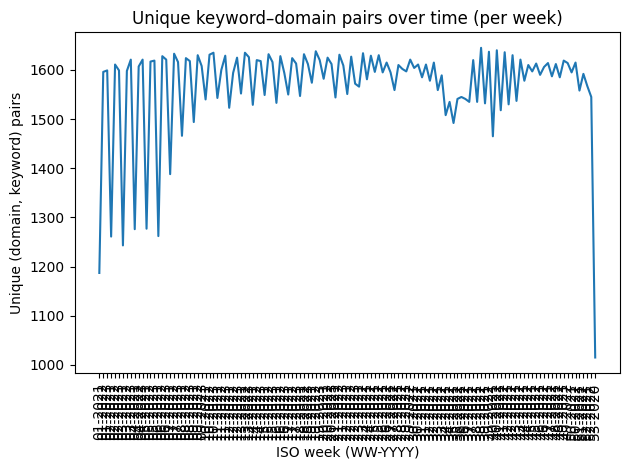

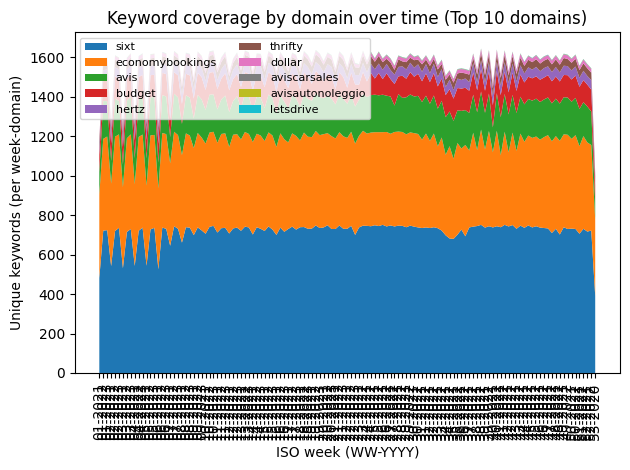

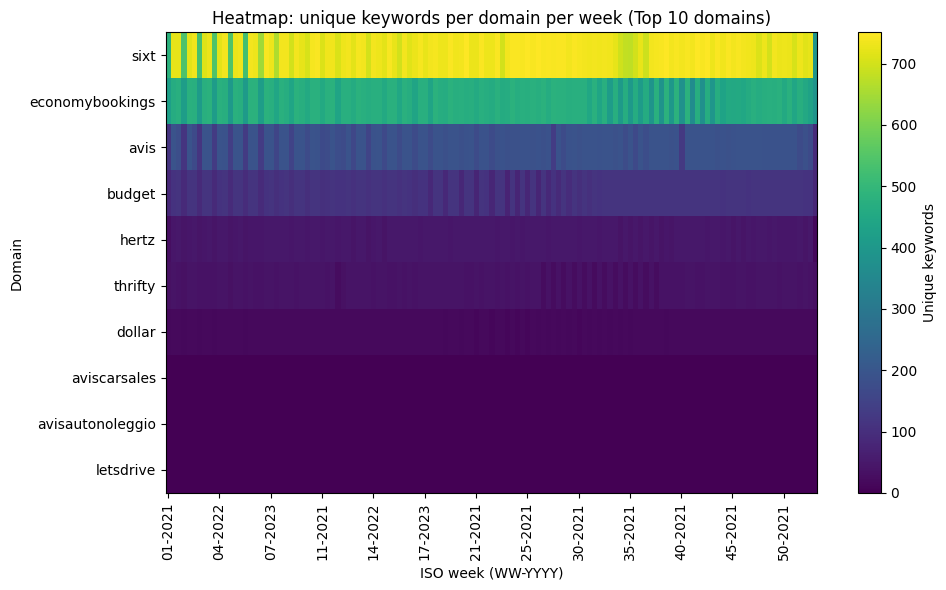

In [4]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE = Path("/content/drive/MyDrive/colab_data/cleaned_cpu/paper")
IN_FP = BASE / "weekly_aggregated_by_week_domain_keyword.parquet"

# Read minimal columns
df = pl.read_parquet(IN_FP, columns=["week", "domain", "keyword"])

# Ensure one row per (week, domain, keyword) already, but keep safe:
df = df.unique(subset=["week", "domain", "keyword"])

# 1) Total unique (domain, keyword) pairs per week
pairs_per_week = (
    df.group_by("week")
      .agg(pl.len().alias("n_pairs"))
      .sort("week")
      .to_pandas()
)

plt.figure()
plt.plot(pairs_per_week["week"], pairs_per_week["n_pairs"])
plt.xticks(rotation=90)
plt.xlabel("ISO week (WW-YYYY)")
plt.ylabel("Unique (domain, keyword) pairs")
plt.title("Unique keyword–domain pairs over time (per week)")
plt.tight_layout()
plt.show()

# 2) Unique keywords per (week, domain) and stacked area for top domains
kw_per_week_domain = (
    df.group_by(["week", "domain"])
      .agg(pl.col("keyword").n_unique().alias("n_keywords"))
      .sort(["week", "domain"])
      .to_pandas()
)

# Pivot to wide (weeks x domains)
wide = kw_per_week_domain.pivot(index="week", columns="domain", values="n_keywords").fillna(0)

# Select top N domains by total activity
TOP_N = 12 if wide.shape[1] >= 12 else wide.shape[1]
top_domains = wide.sum(axis=0).sort_values(ascending=False).head(TOP_N).index.tolist()
wide_top = wide[top_domains]

plt.figure()
plt.stackplot(wide_top.index, *[wide_top[c].values for c in wide_top.columns], labels=wide_top.columns)
plt.xticks(rotation=90)
plt.xlabel("ISO week (WW-YYYY)")
plt.ylabel("Unique keywords (per week-domain)")
plt.title(f"Keyword coverage by domain over time (Top {TOP_N} domains)")
plt.legend(loc="upper left", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# 3) Optional: Heatmap of (week x domain) keyword counts for top domains
plt.figure(figsize=(10, 6))
plt.imshow(wide_top.T.values, aspect="auto", interpolation="nearest")
plt.yticks(range(len(wide_top.columns)), wide_top.columns)
plt.xticks(range(0, len(wide_top.index), max(1, len(wide_top.index)//12)), wide_top.index[::max(1, len(wide_top.index)//12)], rotation=90)
plt.xlabel("ISO week (WW-YYYY)")
plt.ylabel("Domain")
plt.title(f"Heatmap: unique keywords per domain per week (Top {TOP_N} domains)")
plt.colorbar(label="Unique keywords")
plt.tight_layout()
plt.show()
